# Model Comparison

In this notebook we will create several new subreddit prediction models and systematically compare them.

While looking at new models we want to answer the following questions:
- What auxiliary information is important?
- Are different tokenizers better?
- How many words are needed in our Bag-of-Words?
- Do different classification algorithms (XGBoost, Support Vector Machine, Multinomial Logistic Regression, Random Forest)?
- Do more advanced embedding algorithms such as Averaged Word2Vec or Doc2Vec work better?

Obviously the first thing we need to do is load the data

In [1]:
import pandas as pd

#df = pd.read_csv('reddit_data.csv').set_index('id')
df_raw = pd.read_csv('reddit_data.csv')#.set_index('id')

df_raw

,id,title,subreddit
0,t93ec3,This subreddit is closed for new posts and com...,announcements
1,pg006s,COVID denialism and policy clarifications,announcements
2,pbmy5y,"Debate, dissent, and protest on Reddit",announcements
3,nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
4,mi01fg,Second,announcements
...,...,...,...
9456,10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole
9457,10mvlnr,AITA for lashing out at my parents?,AmItheAsshole
9458,10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole
9459,10mvix4,WIBTA if I cancelled a vacation weekend becaus...,AmItheAsshole



## Classes

In order to improve the results I need to test a lot of models. In a separate notebook I've created three classes to help with that. This will organize the information better.

In [2]:
%run Classes.ipynb

In [3]:
obj = Subreddit_Predictor()
obj.add_data(df_raw)
obj.ready_data()

Obviously the first thing we need to do is load the data

In [1]:
import pandas as pd

#df = pd.read_csv('reddit_data.csv').set_index('id')
df_raw = pd.read_csv('reddit_data.csv')#.set_index('id')

df_raw

,id,title,subreddit
0,t93ec3,This subreddit is closed for new posts and com...,announcements
1,pg006s,COVID denialism and policy clarifications,announcements
2,pbmy5y,"Debate, dissent, and protest on Reddit",announcements
3,nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
4,mi01fg,Second,announcements
...,...,...,...
9456,10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole
9457,10mvlnr,AITA for lashing out at my parents?,AmItheAsshole
9458,10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole
9459,10mvix4,WIBTA if I cancelled a vacation weekend becaus...,AmItheAsshole



## Classes

In order to improve the results I need to test a lot of models. In a separate notebook I've created three classes to help with that. This will organize the information better.

In [2]:
%run Classes.ipynb

In [3]:
obj = Subreddit_Predictor()
obj.add_data(df_raw)
obj.ready_data()

We also need to load the results from the previous notebook into this object. We can then compare our results to see improvements.

In [4]:
import pickle as pkl

with open ("human_results.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Results.loc['Human'] = data

with open ("naive_results.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Results.loc['Naive'] = data

with open ("naive_results_mean.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Cross_Validation_Results_avg.loc['Naive'] = data

with open ("naive_results_std.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Cross_Validation_Results_std.loc['Naive'] = data


These results represent the Individual Recall Scores and the Total Accuracy Score of attempting the classify subreddits by hand, "Human", and using a naive Bag-of-Words with Random Forrest modle, "Naive".

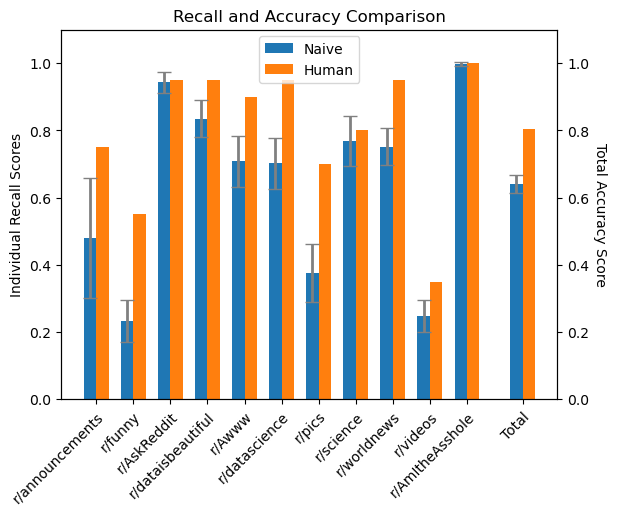

In [5]:
obj.compare([ 'Naive', 'Human'], error_bars=True)

### Naive Model+

The first thing we need to do is recreate our Naive Model. The embedding process uses Bag-of-Words. To make our lives easier in the future, we will create a generalized BoW embedding that can be easily modified.


*Cleaning* - Make everythign lower case and fix some common terms like "[oc]" to make it easier for the tokenizer
*Embedding* - "Training" a BoW model is really just creating a vacob list. We use NLTK's tokenizer
*Classifying* - As in our first approach we will use Random Forrest.

In [6]:
def clean_data(df):
    """
    :param df: Pandas DataFrame with a column 'title', or a Series
    :return: original df with the contents of the 'title' column altered. All lowercase. Replace "[oc]", "(oc)", and "[nsfw]" with "_oc_" and "_nsfw_" respectively.
    """

    if type(df) == pd.Series:
        df = pd.DataFrame(df)
        series = True
    else:
        series = False

    df['title'] = df['title'].apply(lambda s: s.lower())

    df['title'] = df['title'].apply(lambda s: s.replace("[oc]", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(oc)", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[nsfw]", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(nsfw)", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[wip]", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(wip)", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[serious]", "_serious_"))

    if series: df = df['title']

    return df

In [7]:
import nltk

def get_vocab(corpus, tokenizer=nltk.word_tokenize, num_words=False, min_frequency=2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """
    tokenized_corpus = [tokenizer(sentence) for sentence in corpus]
    flat_list = [word for sublist in tokenized_corpus for word in sublist]
    freq_dist = FreqDist(flat_list)
    vocab = [word for word, freq in freq_dist.items() if freq >= min_frequency]
    if num_words:
        vocab = sorted(vocab, key=lambda x: freq_dist[x], reverse=True)
        vocab = vocab[:min(num_words, len(vocab))]
    vocab.sort()
    return vocab


In [8]:

from tqdm import tqdm


def _BoW_embed(titles, vocab, tokenizer=nltk.word_tokenize):
    """
    :param titles: A Pandas Series of titles to embed
    :param vocab: A List of all the words in the vocab
    :return:
    """
    df = pd.DataFrame(titles)
    df['title_tokens'] = df['title'].apply(tokenizer)
    new_cols = {'BoW: ' + word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in tqdm(vocab)}
    #new_cols['Not in BoW'] = df['title_tokens'].apply(lambda lis: count_not_in_list2(lis, vocab))
    new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    new_df = new_df.drop(columns=['title', 'title_tokens'])

    return new_df


In [10]:
from nltk.probability import FreqDist
from collections import Counter


#Naive_BoW = Vectorizer('Naive BoW')

In [14]:
obj.Models_info

{'Naive Model': {'vectorizerName': 'Naive BoW',
  'classifierName': 'RF',
  'description': 'The Naive model using a full BoW vocab and RF with default parameters.'}}

In [32]:
try:
    result = 1 + max(list(obj.Cross_Validation_Results.loc['Naive Model'].index))
except KeyError:
    print('KeyError occurred')

KeyError occurred


In [15]:
obj.validate('Naive Model', 1)

  0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 'Naive Model'

In [13]:
#Naive_BoW._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))

In [14]:
#Naive_BoW._embed = (lambda titles, vocab: _BoW_embed(clean_data(titles), vocab))


In [15]:
#temp_X_train = obj.X_train
#Naive_BoW.train(temp_X_train)

In [16]:
#Naive_BoW.embed(temp_X_train)


In [11]:
from nltk.probability import FreqDist
from collections import Counter


Naive_BoW = Vectorizer('Naive BoW')
Naive_BoW._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))
Naive_BoW._embed = (lambda titles, vocab: _BoW_embed(clean_data(titles), vocab))
temp_X_train = obj.X_train
Naive_BoW.train(temp_X_train)
Naive_BoW.embed(temp_X_train)


100%|██████████| 6402/6402 [01:48<00:00, 58.87it/s]


,BoW: !,BoW: #,BoW: $,BoW: %,BoW: &,BoW: ',BoW: '',BoW: 'd,BoW: 'data,BoW: 'll,...,BoW: 😍💕,BoW: 😍😍,BoW: 😍😍😍,BoW: 😴,BoW: 🙏,BoW: 🤣,BoW: 🥰,BoW: 🥹,BoW: 🥺,BoW: 🧡
id,,,,,,,,,,,,,,,,,,,,,
10q4vr2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10l4k14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10onlbl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10o8gas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10oqsll,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10nolvw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10omphc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10k860k,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:

from sklearn.ensemble import RandomForestClassifier


def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


100%|██████████| 6402/6402 [02:18<00:00, 46.06it/s]


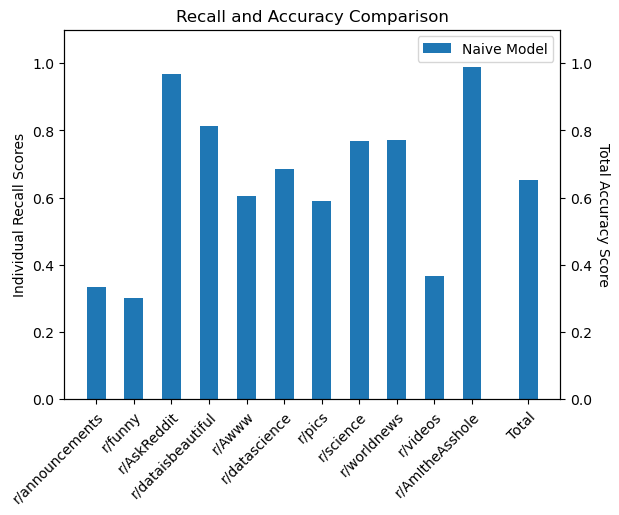

In [13]:

RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_vectorizer(Naive_BoW)
obj.add_feature_vectors('Naive BoW')
obj.add_classifier(RF)
obj.train_model('Naive Model', 'Naive BoW', 'RF',
                description="The Naive model using a full BoW vocab and RF with default parameters."
                )
obj.test_model('Naive Model')
obj.compare(['Naive Model'])